<a href="https://colab.research.google.com/github/chaotiqc/mlstudies/blob/main/atividade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
#import warnings
#warnings.filterwarnings("ignore")

import itertools
import numpy as np
import pandas as pd
import pickle
#import shap

# IMPORTING Keras and TF
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, UpSampling2D, Input, ZeroPadding2D, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
#import tensorflow_probability as tfp

from tensorflow.keras.losses import mse, binary_crossentropy, huber
#from tensorflow.keras.metrics import mean_absolute_error # Corrected import
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# IMPORTING UTILITIES FROM SKLEARN
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score

# PLOTS
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
#rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
#rc('font',**{'family':'serif','serif':['cmr']})

#from kin import kinvar1, kinvar2 # infelizmente, nao ta rodando
#import ml_insights as mli

2.19.0


In [88]:
import tarfile

hl_zip = '/content/drive/MyDrive/Física - Bacharel Lic./deep learning & colisões de partículas/200_HL.csv.tar.gz'
HL = '/content/drive/MyDrive/Física - Bacharel Lic./deep learning & colisões de partículas'

# Abre o arquivo em modo de leitura com compressão gzip
with tarfile.open(hl_zip, 'r:gz') as tar:
    tar.extractall(path=HL)
    print("Descompactação concluída!")


/tmp/ipython-input-2457158391.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=HL)


Descompactação concluída!


In [89]:
data = pd.read_csv('/content/drive/MyDrive/Física - Bacharel Lic./deep learning & colisões de partículas/200_HL.csv')
data = data.drop(columns=['label0'],axis=1)
print(len(data))

335596


In [90]:
data.columns

Index(['Unnamed: 0', 'pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'ptm', 'E1', 'E2',
       'E3', 'E4', 'eta1', 'eta2', 'eta3', 'eta4', 'eta5', 'm12', 'm13', 'm14',
       'm23', 'm24', 'm34', 'm15', 'mt135miss', 'dr12', 'dr13', 'dr14', 'dr23',
       'dr24', 'dr34', 'dr15', 'phi1234', 'ta+', 'ta-', 'mu+', 'mu-', 'e+',
       'e-', 'b-jets', 'njets', 'ma', 'label'],
      dtype='object')

In [91]:
print(data)

        Unnamed: 0     pt1    pt2     pt3    pt4        pt5     ptm  \
0                0   82.51  44.35  244.12   0.00    0.01726  177.07   
1                1   97.46   0.00  121.58  27.26   60.47764   60.25   
2                2   11.72   0.00    0.00   0.00   92.28000  116.58   
3                3   31.74   0.00  124.04   0.00  138.29000  102.47   
4                4   22.34   0.00   98.73  22.90   27.59000   38.97   
...            ...     ...    ...     ...    ...        ...     ...   
335591      335591   20.04   0.00    0.00   0.00   77.40000  120.92   
335592      335592   38.85   0.00   89.02  86.89   27.40000   45.78   
335593      335593  154.35  49.38   81.75  73.24   68.89000   94.16   
335594      335594   52.36   0.00   43.40   0.00   75.12000   81.57   
335595      335595   32.24   0.00  150.00   0.00   75.80000   45.50   

                E1         E2          E3  ...  ta+  ta-  mu+  mu-   e+   e-  \
0        92.357111  86.615928  265.490170  ...  1.0  1.0  0.0  0.0 

In [92]:
data.head(10)

,Unnamed: 0,pt1,pt2,pt3,pt4,pt5,ptm,E1,E2,E3,...,ta+,ta-,mu+,mu-,e+,e-,b-jets,njets,ma,label
0,0,82.51,44.35,244.12,0.00,0.01726,177.07,92.357111,86.615928,265.490170,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,200.0,0
1,1,97.46,0.00,121.58,27.26,60.47764,60.25,212.116155,0.000000,146.962001,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1700.0,1
2,2,11.72,0.00,0.00,0.00,92.28000,116.58,51.941997,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,500.0,1
3,3,31.74,0.00,124.04,0.00,138.29000,102.47,78.270815,0.000000,202.684061,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,200.0,0
4,4,22.34,0.00,98.73,22.90,27.59000,38.97,103.754619,0.000000,232.722765,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,200.0,0
5,5,57.09,38.98,95.04,24.66,36.70000,56.23,80.944915,45.299538,130.111510,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,2000.0,1
6,6,126.59,16.56,54.34,35.67,60.47764,97.50,151.459914,28.010690,61.673908,...,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,200.0,1
7,7,24.99,0.00,150.64,104.51,60.47764,78.62,111.076679,0.000000,707.544113,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,500.0,1
8,8,162.29,0.00,0.00,0.00,184.46000,43.76,739.158991,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,200.0,0
9,9,29.54,0.00,74.96,0.00,30.77000,114.00,29.556290,0.000000,101.057158,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,500.0,1


In [93]:
type(data)

pandas.core.frame.DataFrame

In [94]:
#  Mascara para sinal e background
def selector(y):
    aux_min=int(min(y)) # encontra a menor valor e armazena como inteiro
    aux_max=int(max(y))+1
    sel=[[] for i in range(int(aux_max))]
    for i in range(int(aux_max)):
        sel[i] = np.array([y[k] == float(i) for k in range(len(y))])
    return sel

In [95]:
y = data['label'].values.astype(int) # LABELS
X = data.drop(['label'],axis=1).values # FEATURES # Nao tem como mudar o axis = 0 pq nao ha nenhuma linha com "label"
print(len(y))

335596


In [96]:
# features a serem transformadas (transf de escala), as seis ultimas sao numeros inteiros nao precisa
nfeat=X.shape[1]-6

In [97]:
print(nfeat)

35


## Gráficos

In [98]:
## vou pular essa parte por enqenquanto

## Pré-processamento das features

In [99]:
print(len(data)) #numero de eventos totais

335596


In [100]:
rs = 42
X_train, X0_test, y_train, y0_test = train_test_split(X,y,test_size=0.25,random_state=rs)
X_test, X_val, y_test, y_val = train_test_split(X0_test,y0_test,test_size=0.33,random_state=rs)
print(len(y_train),len(y_test),len(y_val))

251697 56212 27687


In [101]:
scaler = MinMaxScaler() # redimensiona as features em um intervalo entre 0 e 1.
scaler.fit(X_train[:,:nfeat]) # calcula os parametros necessarios para a transformação;

X_train[:,:nfeat] = scaler.transform(X_train[:,:nfeat])
X_test[:,:nfeat]  = scaler.transform(X_test[:,:nfeat])
X_val[:,:nfeat]  = scaler.transform(X_val[:,:nfeat])
print(X_train.shape,X_test.shape)

(251697, 41) (56212, 41)


In [102]:
scaler = StandardScaler() #é o que funciona melhor
scaler.fit(X_train) #reescalono pelo x do treino, mas tanto faz

X_train = scaler.transform(X_train) # realiza a padronização, centralizando e escalando os dados
X_test  = scaler.transform(X_test)
X_val  = scaler.transform(X_val)
print(X_train.shape,X_test.shape)

(251697, 41) (56212, 41)


## Classificador

In [103]:
def DNN(params):

    #reading parameters
    dim_input = params['dim_input'] # dimensao de entrada
    num_classes = params['num_classes'] # numero total de classes para a classificacao
    num_layers = params['num_layers'] #numero de camadas internas
    neurons = params['neurons'] #funcoes de ativacao
    activ = params['activ'] # funcao de ativacao para a camada oculta
    dp = params['dp'] # taxa de dropout (prob de desligar um neuronio)

    # building the neural net

    #camada de entrada
    input_data = Input(shape=(dim_input,), name='input_data') #recebe os dados, shape = numero de colunas ## shape=(dim_input,) especifica que o modelo espera vetores de entrada
    #camada interna
    x = Dense(int(neurons), activation=activ, name='layer_1')(input_data) #recebe os inputs e calculando a funcao de ativacao
    for k in range(1,num_layers-1):
        nome = 'layer_'+str(k+1)
        x = Dense(int(neurons), activation=activ, name=nome)(x) #recebe os inputs e calculando a funcao de ativacao
        x = BatchNormalization()(x) # melhorar performance (estabiliza e acelera o treinamento)
        x = Dropout(dp)(x) # melhorar, performance, desliga alguns que nao estao muito treinados (impede aue os neuronios dependa um do outro)
    #ultima camada
    if num_classes==2:
        xo = Dense(num_classes-1, activation='sigmoid')(x) # se tiver apenas 2 classes sigmoid, nosso caso, 1 neuron na ultima camada
    else:
        xo = Dense(num_classes, activation='softmax')(x) # mais de duas use softmax

    model = Model(inputs=input_data, outputs=xo)

    return model

In [104]:
import tensorflow as tf

#Building the Classifier #
def classifier_DNN_builder(feats,labels,params,opt,lr,epochs,batch_size):

    X_train, _, X_val = feats
    y_train, _, y_val = labels
    sel_train = selector(y_train)
    sel_eval  = selector(y_val)

    # number of S,B MC events in the sample
    NS=len(y_train[sel_train[1]])
    NB=len(y_train[sel_train[0]])


    # fitting the model
    eval_set = [X_val, y_val]
    ###############################################
    checkpoint_filepath = '/content/drive/MyDrive/Física - Bacharel Lic./deep learning & colisões de partículas/best_weights.weights.h5'
    #salvar o melhor modelo, melhor modelo nem sempre é o modelo da ultima epoca
    model_checkpoint_callback = ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

    # instantiate the model
    model = DNN(params)


    opt = opt
    #opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    # para melhorar o learning rate, foca na regiao do minimo
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=25, min_lr=1e-6) #factor = 0.5 diminui na metade o LR apos 25 epocas



    ########## Early stopping
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=25)

    ######################################
    # Compilation
    model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
    model.summary()

    # fitting the model
    history=model.fit(x=X_train,y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_callback, reduce_lr, stop], #,TensorBoard(log_dir='/tmp/autoencoder')],
                    #validation_split = 0.25, #faz o que a linha de debaixo faz
                    validation_data=(eval_set),
                    verbose = 1)

    #model.save_weights('/content/drive/MyDrive/Física - Bacharel Lic./deep learning & colisões de partículas/class_weights.h5')

    return model, history

In [105]:
params_teste = {
    'dim_input': 20,
    'num_classes': 2,
    'num_layers': 3,
    'neurons': 64,
    'activ': 'relu',
    'dp': 0.3
}

# 2. Crie o modelo
meu_modelo = DNN(params_teste)

# 3. Visualize
meu_modelo.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)         │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,825 (22.75 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 128 (512.00 B)

In [106]:
# escolha dos hiperparametros

dim_input = X.shape[1]
params = {'dim_input': dim_input,
          'num_classes': 2,
          'num_layers': 3,
          'neurons': 64,
          'activ': 'relu',
          'dp': 0.15}

lr = 2e-3 #LR inicial
epochs = 100
batch_size = 64
opt = Adam(learning_rate=lr) #'adam', tem momentum

feats = [X_train,X_test,X_val]
labels= [y_train,y_test,y_val]

model, history = classifier_DNN_builder(feats,labels,params,opt,lr,epochs,batch_size)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)         │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,041 (27.50 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8974 - loss: 0.2538 - val_accuracy: 0.9356 - val_loss: 0.1710 - learning_rate: 0.0020
Epoch 2/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9343 - loss: 0.1764 - val_accuracy: 0.9370 - val_loss: 0.1661 - learning_rate: 0.0020
Epoch 3/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9360 - loss: 0.1704 - val_accuracy: 0.9369 - val_loss: 0.1648 - learning_rate: 0.0020
Epoch 4/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9371 - loss: 0.1688 - val_accuracy: 0.9374 - val_loss: 0.1643 - learning_rate: 0.0020
Epoch 5/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9363 - loss: 0.1674 - val_accuracy: 0.9368 - val_loss: 0.1640 - learning_rate: 0.0020
Epoch 6/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9370 - loss: 0.1670 - val_accuracy: 0.9371 - val_loss: 0.1627 - learning_rate: 0.0020
Epoch 7/100
3933/3933 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accura

por esse metodo,tá dando erro para salvar os pesos (ta comentado la em cima)

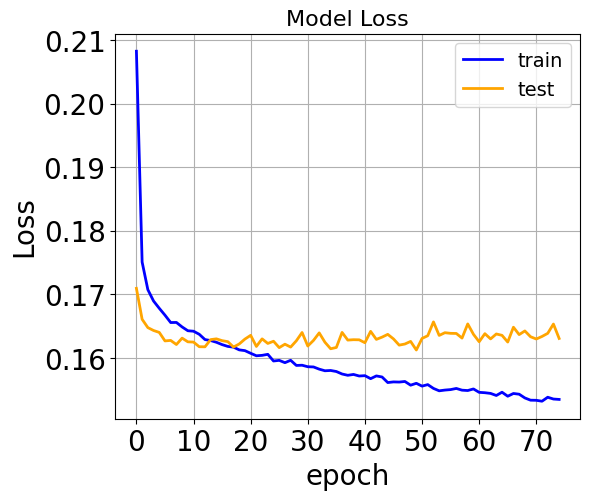

In [113]:
plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], lw=2, color='blue')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.title('Model Loss',size=16)
plt.ylabel('Loss',size=20)
plt.xlabel('epoch',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(True)
#plt.yscale('log')
plt.legend(['train','test'], loc='best')
plt.rc('legend',fontsize=14)
#plt.savefig('../figures/'+fold+'_loss_'+caso+'.pdf')
plt.show()

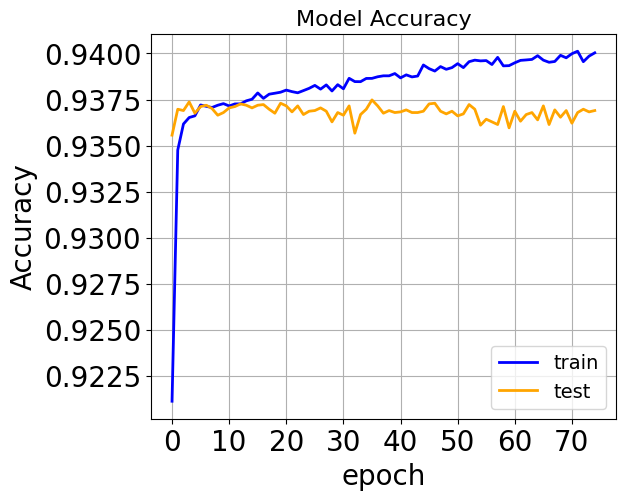

In [114]:
plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'], lw=2, color='blue')
plt.plot(history.history['val_accuracy'], lw=2, color='orange')
plt.title('Model Accuracy',size=16)
plt.ylabel('Accuracy',size=20)
plt.xlabel('epoch',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(True)
#plt.yscale('log')
plt.legend(['train','test'], loc='best')
plt.rc('legend',fontsize=14)
#plt.savefig('../figures/'+fold+'_accuracy_'+caso+'.pdf')
plt.show()

In [109]:
model.load_weights('/content/drive/MyDrive/Física - Bacharel Lic./deep learning & colisões de partículas/best_weights.weights.h5')
model.compile(loss='binary_crossentropy',optimizer=opt)

In [115]:
# make predictions for test data
scores = model.predict(X_test)
y_pred = np.round(scores) #prestar atencao aqui


minS=np.min(scores)
maxS=np.max(scores)
escores=(1./(maxS-minS))*(scores-minS)
#print(escores[sel_test[1]])
sel_test  = selector(y_test)
scores_S =np.array(escores[sel_test[1]])
scores_B =np.array(escores[sel_test[0]])

#filename = 'prmean_squared_error(test_e,ypred)ediction_'+str(dp)+'_'+str(L2_reg)+'.npy'
#np.save(filename,pred)
acc = accuracy_score(y_test,y_pred)

## CC accuracy
print("acc:%.3f"%(100*acc),"%")

1757/1757 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
acc:93.690 %


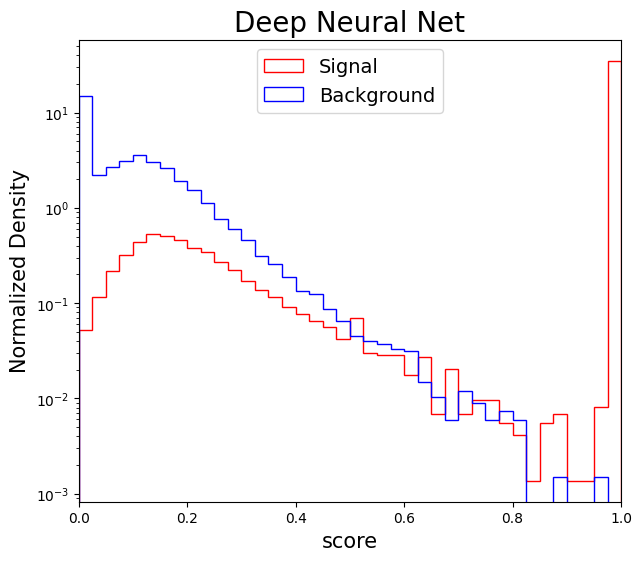

In [116]:
nbins = np.arange(0,1.025,0.025)

plt.figure(figsize=(7,6))
plt.hist(scores_S, bins=nbins, density=True, lw=2, color='red', label=r'Signal', histtype='step')
plt.hist(scores_B, bins=nbins, density=True, color='blue', lw=2, label=r'Background', histtype='step')
plt.xlabel(r'score', fontsize=15)
plt.ylabel(r'Normalized Density', fontsize=15)
plt.xlim([0.,1])
#plt.ylim([1.e-3,7])
plt.yscale('log')
plt.title(r'Deep Neural Net', fontsize=20)
plt.legend(loc="upper center")
#plt.savefig('results/dnn_scores.pdf')
plt.show()

Normalized confusion matrix
[[0.99 0.01]
 [0.11 0.89]]


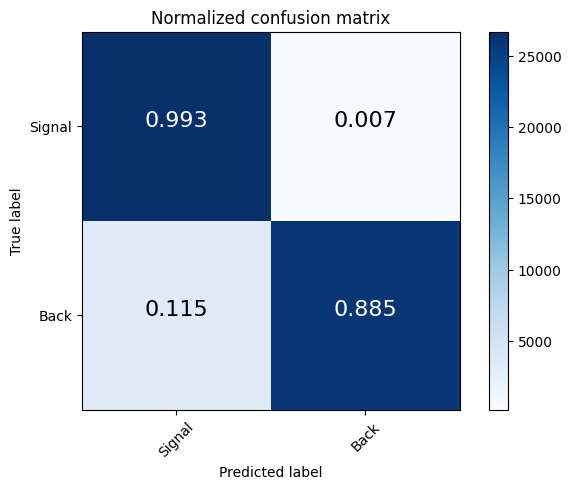

In [117]:
class_names=['Signal','Back']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:04.3f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')
#plt.savefig('results/cm_bdt_preliminary.pdf')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

#
#plt.savefig('results/bdt_cmatrix.pdf')
plt.show()